In [1]:
import os
os.environ['LD_LIBRARY_PATH'] = '/usr/local/lib/:' + os.environ.get('LD_LIBRARY_PATH', '')

In [10]:
print(os.environ['LD_LIBRARY_PATH'])

/usr/local/lib/:/usr/local/lib/:


In [2]:
import ctypes
ctypes.CDLL('/usr/local/lib/libfranka.so.0.13')

<CDLL '/usr/local/lib/libfranka.so.0.13', handle 5f85f08afbc0 at 0x742f1ddc74c0>

In [1]:
from franky import Affine, CartesianMotion, Robot, ReferenceType, RealtimeConfig, \
     JointWaypointMotion, JointWaypoint
import franky

In [2]:
# with franky.RobotWebSession("172.168.0.2", 'root', 'rootrootroot') as web_connection:
#     web_connection.take_control(wait_timeout=15)
#     web_connection.unlock_brakes()
#     web_connection.enable_fci()

In [3]:
# web_connection = franky.RobotWebSession("172.168.0.2", 'root', 'rootrootroot')
# web_connection.open()
# web_connection.take_control(wait_timeout=10)
# web_connection.unlock_brakes()
# web_connection.enable_fci()
# web_connection.close()

In [2]:
robot = Robot("172.168.0.2", realtime_config=RealtimeConfig.Ignore)
robot.relative_dynamics_factor = 0.5

In [13]:
robot.recover_from_errors()

True

In [4]:
robot.current_joint_state.position

array([-5.43883276e-05, -2.99956108e-01, -7.80612414e-05, -1.80010990e+00,
       -2.34706799e-04,  1.49979859e+00,  6.49881740e-01])

In [25]:
robot.current_pose.end_effector_pose

Affine(t=[0.450044 9.98047e-05 0.549995], q=[1 0.000181817 -0.000123994 5.83873e-05])

In [7]:
motion = CartesianMotion(Affine([-0.2, 0.0, 0.0]), ReferenceType.Relative)

In [18]:
motion = CartesianMotion(
    Affine([0.45, 0, 0.55], [1, 0, 0, 0]), ReferenceType.Absolute)

In [14]:
motion = JointWaypointMotion([
    JointWaypoint([0.0,  -0.3, 0.0, -1.8, 0.0, 1.5,  0.65])])

In [19]:
robot.move(motion, asynchronous=True)

In [9]:
gripper = franky.Gripper("172.168.0.2")

In [10]:
gripper.open(0.02)

True

In [15]:
import numpy as np

In [16]:
vel = 0.03
gripper.open(vel)
try:
    fut = None
    for w in np.linspace(0, 100, 100 * 10):
        if fut is not None and not fut.wait(0):
            gripper.terminate_command()
        fut = gripper.move_async(w * gripper.state.max_width, vel)
except KeyboardInterrupt:
    gripper.stop()

AttributeError: 'franky._franky.Gripper' object has no attribute 'terminate_command'

--------
# Now starts Kinova

In [1]:
import collections
collections.MutableMapping = collections.abc.MutableMapping
collections.MutableSequence = collections.abc.MutableSequence
collections.MutableSet = collections.abc.MutableSet

In [2]:
import collections
import time
import threading

In [3]:
from kortex_api.autogen.client_stubs.ActuatorConfigClientRpc import ActuatorConfigClient
from kortex_api.autogen.client_stubs.BaseClientRpc import BaseClient
from kortex_api.autogen.client_stubs.BaseCyclicClientRpc import BaseCyclicClient
from kortex_api.autogen.messages import Base_pb2, BaseCyclic_pb2, ActuatorConfig_pb2

from kortex_api.TCPTransport import TCPTransport
from kortex_api.UDPTransport import UDPTransport

from kortex_api.RouterClient import RouterClient, RouterClientSendOptions
from kortex_api.SessionManager import SessionManager
from kortex_api.autogen.messages import Session_pb2

In [4]:
import geom
import numpy as np
import ruckig
import matplotlib.pyplot as plt

import importlib
# importlib.reload(ruckig)

In [5]:
transport = TCPTransport()
router = RouterClient(transport, RouterClient.basicErrorCallback)

transport.connect('192.168.1.10', 10000)  # 10000 is the default TCP port

In [6]:
session_info = Session_pb2.CreateSessionInfo()
session_info.username = "admin"
session_info.password = "admin"
session_info.session_inactivity_timeout = 1000 * 1000   # (milliseconds)
session_info.connection_inactivity_timeout = 1000 * 1000 # (milliseconds)

sessionManager = SessionManager(router)
sessionManager.CreateSession(session_info)

In [7]:
base = BaseClient(router)
base.SetServoingMode(Base_pb2.ServoingModeInformation(servoing_mode = Base_pb2.SINGLE_LEVEL_SERVOING))

In [11]:
base_cyclic = BaseCyclicClient(router)  # upd_router
actuator_config = ActuatorConfigClient(router)

In [12]:
action_type = Base_pb2.RequestedActionType()
action_type.action_type = Base_pb2.REACH_JOINT_ANGLES
action_list = base.ReadAllActions(action_type)
action_handle = None
for action in action_list.action_list:
    if action.name == "Home":
        action_handle = action.handle

In [13]:
def check_for_end_or_abort(e):
    """Return a closure checking for END or ABORT notifications

    Arguments:
    e -- event to signal when the action is completed
        (will be set when an END or ABORT occurs)
    """
    def check(notification, e = e):
        print("EVENT : " + \
              Base_pb2.ActionEvent.Name(notification.action_event))
        if notification.action_event == Base_pb2.ACTION_END or \
           notification.action_event == Base_pb2.ACTION_ABORT:
            e.set()
    return check

In [42]:
# assert action_handle is not None, "Can't reach safe position. Exiting"

# e = threading.Event()
# notification_handle = base.OnNotificationActionTopic(
#     check_for_end_or_abort(e),
#     Base_pb2.NotificationOptions()
# )

base.ExecuteActionFromReference(action_handle)
# finished = e.wait(30)  # seconds
# base.Unsubscribe(notification_handle)

In [35]:
feedback = base_cyclic.RefreshFeedback()
pos =  geom.Transform3D(np.array([feedback.base.tool_pose_x, feedback.base.tool_pose_y, feedback.base.tool_pose_z]),
    geom.euler_to_quat(
        geom.degrees_to_radians(
            np.array([feedback.base.tool_pose_theta_x, feedback.base.tool_pose_theta_y, feedback.base.tool_pose_theta_z]))))

In [36]:
# target_pos = geom.Transform3D(pos.translation + [0.02, 0.02, 0.00], pos.quaternion)
# target_pos = geom.Transform3D(pos.translation + [0.04, 0.04, 0.025], pos.quaternion)
target_pos = geom.Transform3D(pos.translation + [0.08, 0.08, 0.1], pos.quaternion)

In [37]:
joints = np.array([a.position for a in feedback.actuators])

In [38]:
euler = geom.radians_to_degrees(geom.quat_to_euler(target_pos.quaternion))
ik_data = Base_pb2.IKData()
ik_data.cartesian_pose.x = target_pos.translation[0]
ik_data.cartesian_pose.y = target_pos.translation[1]
ik_data.cartesian_pose.z = target_pos.translation[2]
ik_data.cartesian_pose.theta_x = euler[0]
ik_data.cartesian_pose.theta_y = euler[1]
ik_data.cartesian_pose.theta_z = euler[2]

for a in joints:
    ja = ik_data.guess.joint_angles.add()
    ja.value = a

joint_angels = base.ComputeInverseKinematics(ik_data)
target_joints = np.array([a.value for a in joint_angels.joint_angles])

In [39]:
def normalise_angles(target, base, period=360):
    res = target - base
    res[res > period / 2] -= period
    res[res < -period / 2] += period
    return base + res

-----
## Low level control

In [5]:
transport = TCPTransport()
router = RouterClient(transport, RouterClient.basicErrorCallback)
transport.connect('192.168.1.10', 10000)

In [6]:
session_info = Session_pb2.CreateSessionInfo()
session_info.username = "admin"
session_info.password = "admin"
session_info.session_inactivity_timeout = 1000 * 1000   # (milliseconds)
session_info.connection_inactivity_timeout = 1000 * 1000 # (milliseconds)

sessionManager = SessionManager(router)
sessionManager.CreateSession(session_info)

In [7]:
base = BaseClient(router)
base.SetServoingMode(Base_pb2.ServoingModeInformation(servoing_mode = Base_pb2.SINGLE_LEVEL_SERVOING))

In [8]:
udp_transport = UDPTransport()
upd_router = RouterClient(udp_transport, RouterClient.basicErrorCallback)
udp_transport.connect('192.168.1.10', 10001)

udp_session = SessionManager(upd_router)
udp_session.CreateSession(session_info)

In [9]:
base_cyclic = BaseCyclicClient(upd_router)
actuator_config = ActuatorConfigClient(upd_router)

In [34]:
action_list = base.ReadAllActions(
    Base_pb2.RequestedActionType(action_type = Base_pb2.REACH_JOINT_ANGLES))
action_handle = [a.handle for a in action_list.action_list
                 if a.name == "Home"][0]

def check(n, e):
    if n.action_event in [Base_pb2.ACTION_END, Base_pb2.ACTION_ABORT]:
        e.set()

e = threading.Event()
notification_handle = base.OnNotificationActionTopic(
    lambda n: check(n, e), Base_pb2.NotificationOptions())

base.ExecuteActionFromReference(action_handle)
finished = e.wait(30)
if not finished:
    raise Exception("Home position not reached")
base.Unsubscribe(notification_handle)


In [40]:
feedback = base_cyclic.RefreshFeedback()
control = ruckig.Ruckig(7, 1 / 1000)  # 40 hz
inp_ctrl = ruckig.InputParameter(7)
inp_ctrl.current_position = ([a.position for a in feedback.actuators])
inp_ctrl.current_velocity = ([a.velocity for a in feedback.actuators])

inp_ctrl.target_velocity = [0.0] * 7
inp_ctrl.target_acceleration = [0.0] * 7
inp_ctrl.target_position = normalise_angles(target_joints, inp_ctrl.current_position)

inp_ctrl.max_position = [np.inf, 128.9, np.inf, 147.8, np.inf, 120.3, np.inf]
inp_ctrl.min_position = [-np.inf, -128.9, -np.inf, -147.8, -np.inf, -120.3, -np.inf]
inp_ctrl.max_velocity = [20.0] * 7
inp_ctrl.max_acceleration = [15.0] * 7
inp_ctrl.max_jerk = [6.0] * 7

In [41]:
# log = collections.defaultdict(list)
actuator_mode = [ActuatorConfig_pb2.POSITION] * 7

command = BaseCyclic_pb2.Command()
for i in range(7):
    act = command.actuators.add()

send_option = RouterClientSendOptions()
send_option.timeout_ms = 50

base.SetServoingMode(Base_pb2.ServoingModeInformation(servoing_mode=Base_pb2.LOW_LEVEL_SERVOING))
feedback = base_cyclic.RefreshFeedback()
out = ruckig.OutputParameter(7)
res = ruckig.Result.Working
start = time.monotonic()
count = 0

try:
    while res == ruckig.Result.Working:
        cur_pos = np.array([a.position for a in feedback.actuators])
        cur_vel = np.array([a.velocity for a in feedback.actuators])
        # inp_ctrl.current_position = cur_pos
        # inp_ctrl.current_velocity = cur_vel
        inp_ctrl.target_position = normalise_angles(target_joints, inp_ctrl.current_position)

        res = control.update(inp_ctrl, out)
        # log['pos/current'].append(normalise_angles(cur_pos, inp_ctrl.current_position))
        # log['pos/target'].append(inp_ctrl.target_position)
        # log['vel/current'].append(cur_vel)
        # log['pos/output'].append(out.new_position)
        # log['vel/output'].append(out.new_velocity)
        out.pass_to_input(inp_ctrl)

        command.frame_id = (command.frame_id + 1) % 65536
        for i in range(7):
            command.actuators[i].command_id = command.frame_id
            # mode = ActuatorConfig_pb2.POSITION if pos_control else ActuatorConfig_pb2.VELOCITY
            mode = ActuatorConfig_pb2.POSITION
            if actuator_mode[i] != mode:
                actuator_config.SetControlMode(
                    ActuatorConfig_pb2.ControlModeInformation(control_mode=mode), deviceId=i+1)
                actuator_mode[i] = mode

            # For test, we try the same position
            # command.actuators[i].position = feedback.actuators[i].position
            command.actuators[i].position = out.new_position[i]
            # command.actuators[i].velocity = out.new_velocity[i]

        # log['mode'].append([actuator_mode[i] for i in range(7)])
        feedback = base_cyclic.Refresh(command, 0, send_option)
        count += 1
        if count % 400 == 399:
            print(f'Running {count / (time.monotonic() - start):.2f} hz')

finally:
    # for i in range(7):
    #     actuator_config.SetControlMode(
    #         ActuatorConfig_pb2.ControlModeInformation(control_mode=ActuatorConfig_pb2.POSITION),
    #         deviceId=i+1)
    # command.frame_id = (command.frame_id + 1) % 65536
    # for i in range(7):
    #     command.actuators[i].command_id = command.frame_id
    #     command.actuators[i].position = feedback.actuators[i].position
    # feedback = base_cyclic.Refresh(command, 0, send_option)

    base.SetServoingMode(Base_pb2.ServoingModeInformation(servoing_mode=Base_pb2.SINGLE_LEVEL_SERVOING))
    base.Stop()

Running 1601.02 hz
Running 1647.74 hz
Running 1660.14 hz
Running 1664.84 hz
Running 1668.35 hz
Running 1671.41 hz
Running 1671.79 hz
Running 1674.66 hz
Running 1676.20 hz
Running 1675.39 hz
Running 1674.93 hz
Running 1677.47 hz


In [52]:
log = collections.defaultdict(list)
actuator_mode = [ActuatorConfig_pb2.POSITION] * 7

base.SetServoingMode(Base_pb2.ServoingModeInformation(servoing_mode=Base_pb2.SINGLE_LEVEL_SERVOING))
try:
    feedback = base_cyclic.RefreshFeedback()
    out = ruckig.OutputParameter(7)
    res = ruckig.Result.Working
    start = time.monotonic()
    count = 0
    while res == ruckig.Result.Working:
        cur_pos = np.array([a.position for a in feedback.actuators])
        cur_vel = np.array([a.velocity for a in feedback.actuators])
        inp_ctrl.current_position = cur_pos
        # inp_ctrl.current_velocity = cur_vel
        inp_ctrl.target_position = normalise_angles(target_joints, inp_ctrl.current_position)

        res = control.update(inp_ctrl, out)
        log['pos/current'].append(normalise_angles(cur_pos, inp_ctrl.current_position))
        log['pos/target'].append(inp_ctrl.target_position)
        log['vel/current'].append(cur_vel)
        log['pos/output'].append(out.new_position)
        log['vel/output'].append(out.new_velocity)
        out.pass_to_input(inp_ctrl)

        joint_speeds = Base_pb2.JointSpeeds()
        for i in range(7):
            js = joint_speeds.joint_speeds.add()
            js.joint_identifier = i
            js.value = out.new_velocity[i]
            js.duration = 0

        base.SendJointSpeedsCommand(joint_speeds)
        feedback = base_cyclic.RefreshFeedback()
        count += 1
        if count % 100 == 99:
            print(f'Running {count / (time.monotonic() - start):.2f} hz')
finally:
    base.Stop()

Running 20.00 hz


KeyboardInterrupt: 

In [56]:
base.ClearFaults()
base.ExecuteActionFromReference(action_handle)

In [53]:
for k in log:
    log[k] = np.array(log[k])

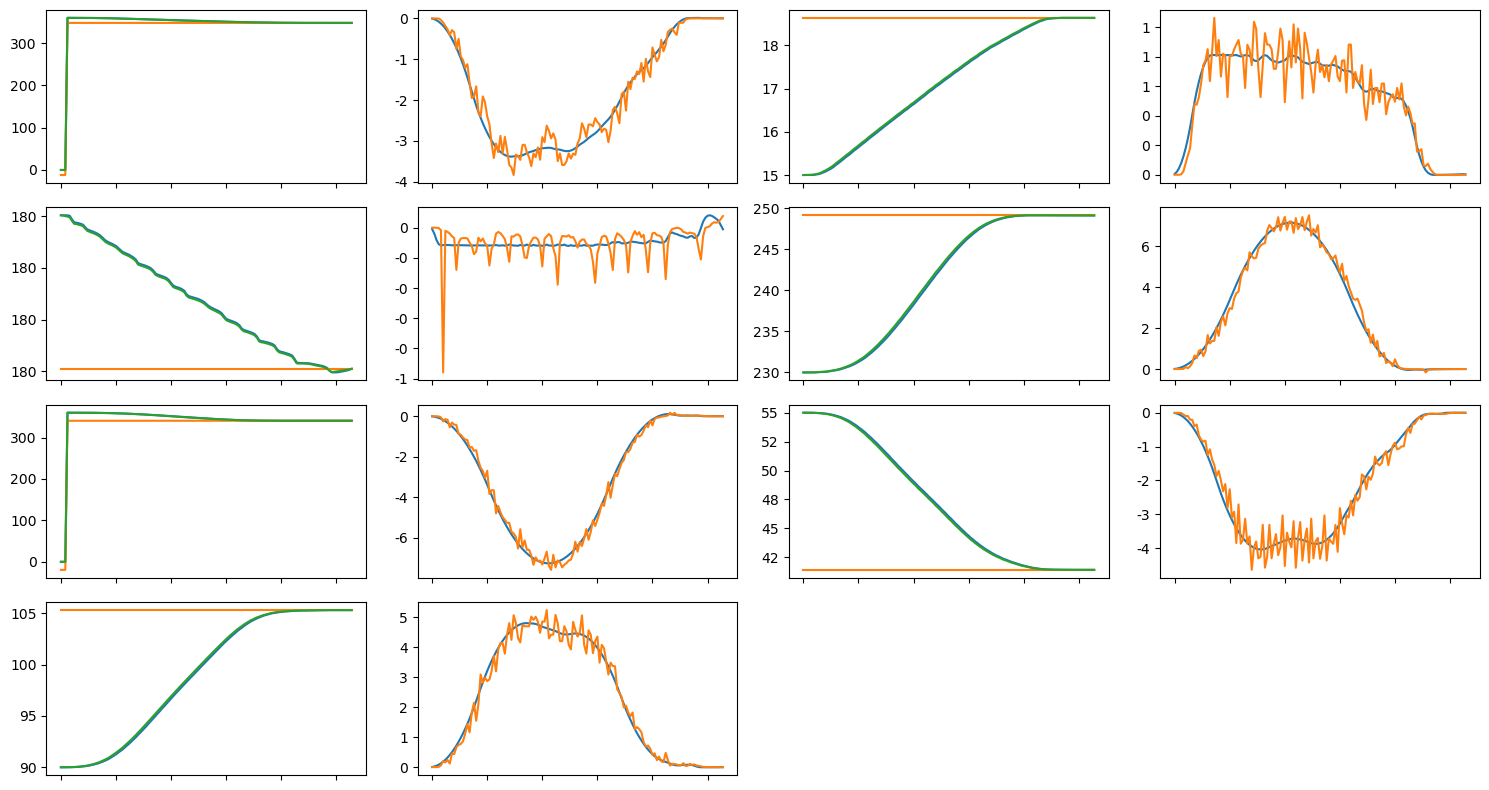

In [54]:
fig, axs = plt.subplots(4, 4, figsize=(15, 8))
for i in range(7):
    row = i // 2
    col = (i % 2) * 2
    axs[row, col].plot(log['pos/current'][:, i])
    axs[row, col].plot(log['pos/target'][:, i])
    axs[row, col].plot(log['pos/output'][:, i])
    axs[row, col].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0f}'))
    axs[row, col].tick_params(axis='x', labelbottom=False)

    axs[row, col + 1].plot(log['vel/output'][:, i])
    axs[row, col + 1].plot(log['vel/current'][:, i])
    axs[row, col + 1].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0f}'))
    axs[row, col + 1].tick_params(axis='x', labelbottom=False)

# Hide the empty subplots
for j in range(7, 8):
    row = j // 2
    col = (j % 2) * 2
    fig.delaxes(axs[row, col])
    fig.delaxes(axs[row, col + 1])

plt.tight_layout()
plt.show()

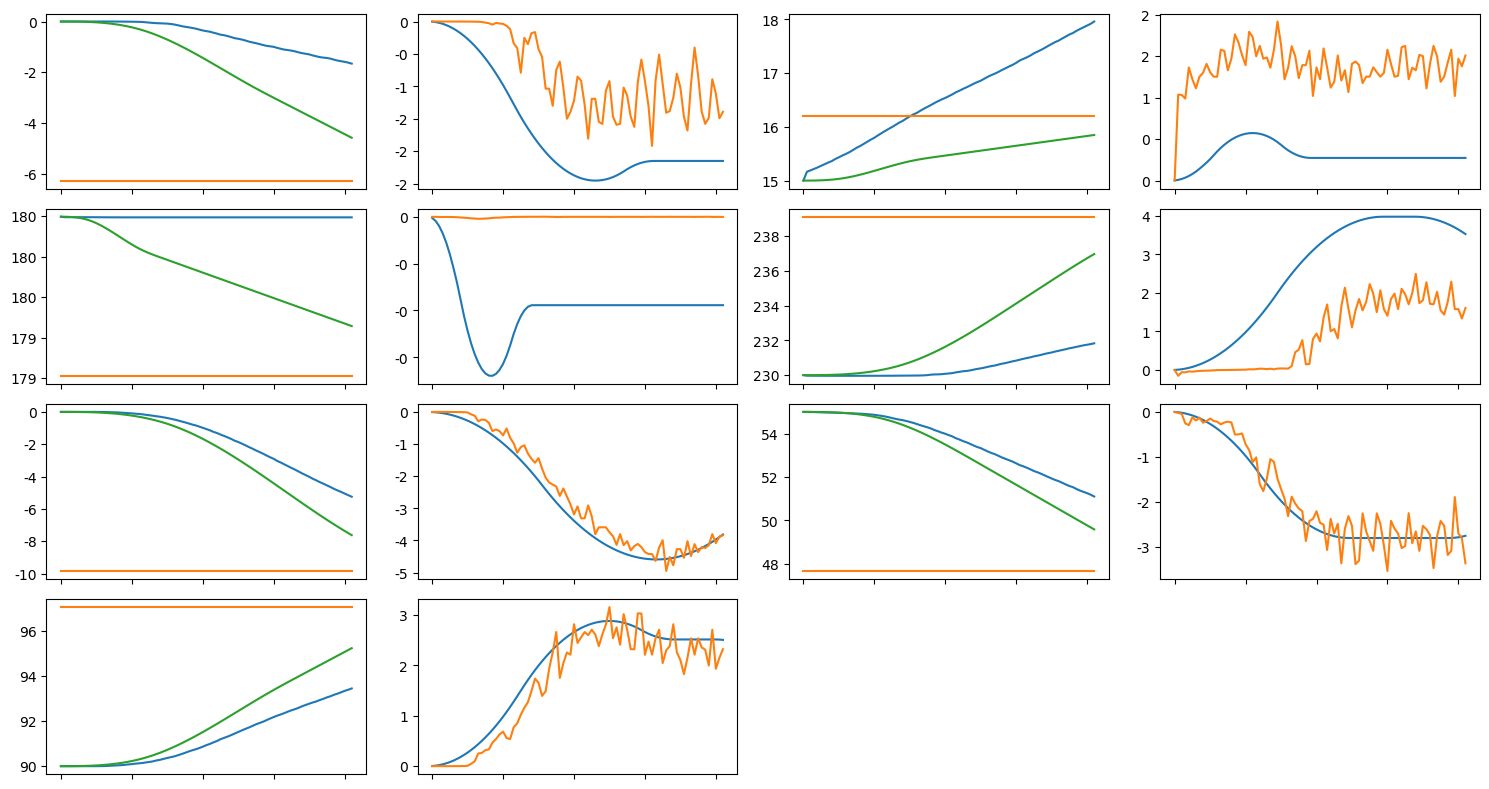

In [ ]:
fig, axs = plt.subplots(4, 4, figsize=(15, 8))
for i in range(7):
    row = i // 2
    col = (i % 2) * 2
    axs[row, col].plot(log['pos/current'][:, i])
    axs[row, col].plot(log['pos/target'][:, i])
    axs[row, col].plot(log['pos/output'][:, i])
    axs[row, col].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0f}'))
    axs[row, col].tick_params(axis='x', labelbottom=False)

    axs[row, col + 1].plot(log['vel/output'][:, i])
    axs[row, col + 1].plot(log['vel/current'][:, i])
    axs[row, col + 1].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0f}'))
    axs[row, col + 1].tick_params(axis='x', labelbottom=False)

# Hide the empty subplots
for j in range(7, 8):
    row = j // 2
    col = (j % 2) * 2
    fig.delaxes(axs[row, col])
    fig.delaxes(axs[row, col + 1])

plt.tight_layout()
plt.show()

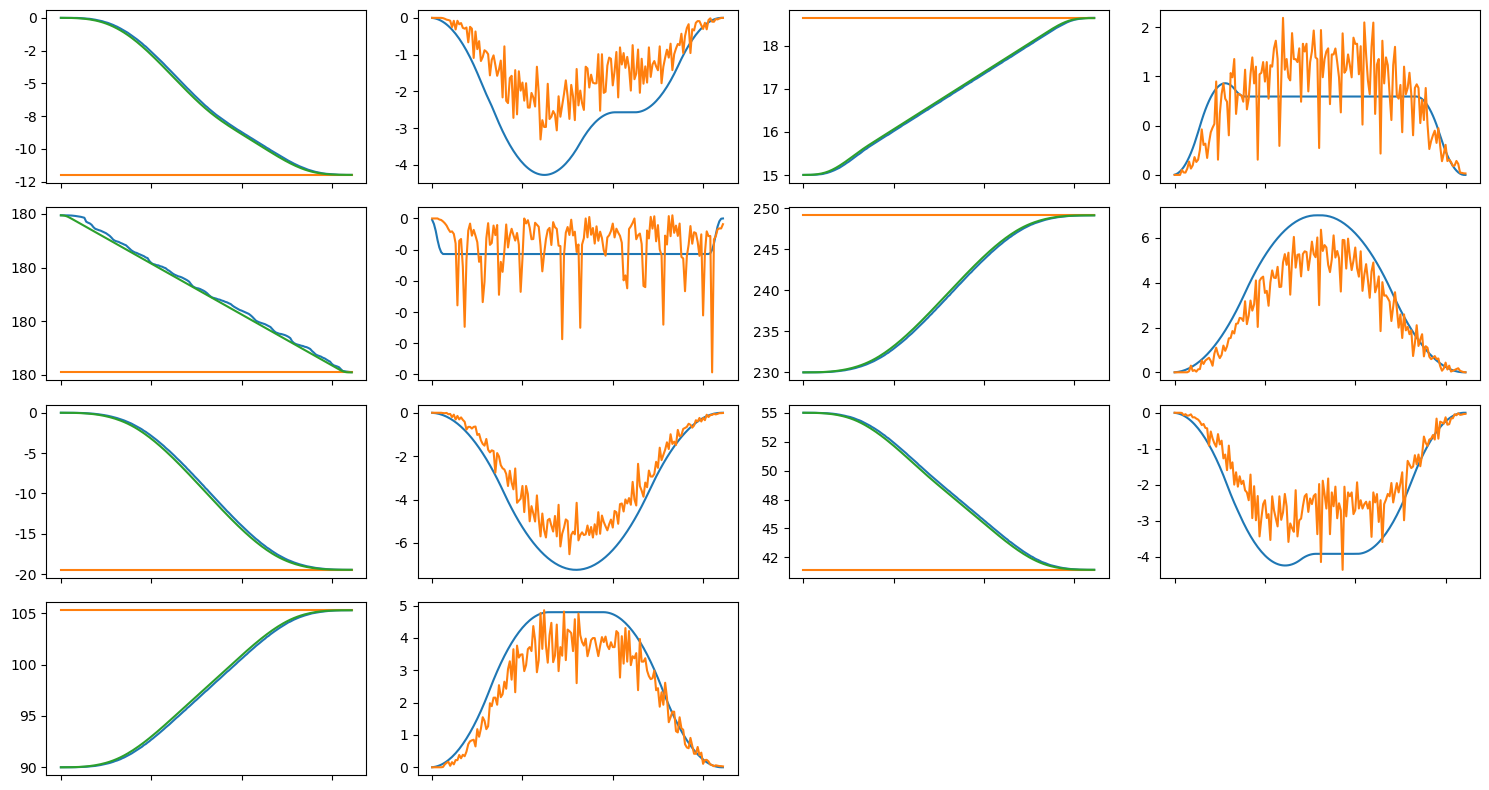

In [ ]:
fig, axs = plt.subplots(4, 4, figsize=(15, 8))
for i in range(7):
    row = i // 2
    col = (i % 2) * 2
    axs[row, col].plot(log['pos/current'][:, i])
    axs[row, col].plot(log['pos/target'][:, i])
    axs[row, col].plot(log['pos/output'][:, i])
    axs[row, col].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0f}'))
    axs[row, col].tick_params(axis='x', labelbottom=False)

    axs[row, col + 1].plot(log['vel/output'][:, i])
    axs[row, col + 1].plot(log['vel/current'][:, i])
    axs[row, col + 1].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0f}'))
    axs[row, col + 1].tick_params(axis='x', labelbottom=False)

# Hide the empty subplots
for j in range(7, 8):
    row = j // 2
    col = (j % 2) * 2
    fig.delaxes(axs[row, col])
    fig.delaxes(axs[row, col + 1])

plt.tight_layout()
plt.show()

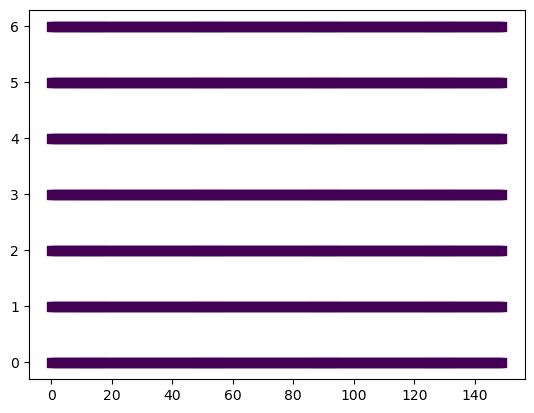

In [52]:
d_time, d_dim = np.meshgrid(range(len(log['mode'])), range(7), indexing='ij')
plt.scatter(d_time.flatten(), d_dim.flatten(), c=log['mode'].flatten(), cmap='viridis', marker='s')
plt.show()

In [ ]:
actuator_config.GetControlLoopParameters(
    ActuatorConfig_pb2.LoopSelection(loop_selection=ActuatorConfig_pb2.JOINT_POSITION))

In [64]:
router_options = RouterClientSendOptions()
router_options.timeout_ms = 1000
sessionManager.CloseSession(router_options)
transport.disconnect()

In [284]:
log = collections.defaultdict(list)
actuator_mode = [ActuatorConfig_pb2.POSITION] * 7

base.SetServoingMode(Base_pb2.ServoingModeInformation(servoing_mode=Base_pb2.LOW_LEVEL_SERVOING))
try:
    feedback = base_cyclic.RefreshFeedback()
    out = ruckig.OutputParameter(7)
    res = ruckig.Result.Working
    start = time.monotonic()
    count = 0
    while res == ruckig.Result.Working:
        cur_pos = np.array([a.position for a in feedback.actuators])
        cur_vel = np.array([a.velocity for a in feedback.actuators])
        # inp_ctrl.current_position = cur_pos
        # inp_ctrl.current_velocity = cur_vel
        inp_ctrl.target_position = normalise_angles(target_joints, inp_ctrl.current_position)

        res = control.update(inp_ctrl, out)
        log['pos/current'].append(normalise_angles(cur_pos, inp_ctrl.current_position))
        log['pos/target'].append(inp_ctrl.target_position)
        log['vel/current'].append(cur_vel)
        log['pos/output'].append(out.new_position)
        log['vel/output'].append(out.new_velocity)
        out.pass_to_input(inp_ctrl)

        command.frame_id = (command.frame_id + 1) % 65536
        for i in range(7):
            command.actuators[i].command_id = command.frame_id
            # If the difference between the target and current position is less than 0.3 degrees,
            # use position control. Otherwise, use velocity control
            pos_control = abs(out.new_position[i] - inp_ctrl.target_position[i]) < 0.3 or abs(out.new_velocity[i]) < 0.1
            # mode = ActuatorConfig_pb2.POSITION if pos_control else ActuatorConfig_pb2.VELOCITY
            mode = ActuatorConfig_pb2.POSITION
            if actuator_mode[i] != mode:
                actuator_config.SetControlMode(ActuatorConfig_pb2.ControlModeInformation(control_mode=mode), deviceId=i+1)
                actuator_mode[i] = mode

            command.actuators[i].position = out.new_position[i]
            command.actuators[i].velocity = out.new_velocity[i]

        log['mode'].append([actuator_mode[i] for i in range(7)])
        feedback = base_cyclic.Refresh(command, 0, send_option)
        count += 1
        if count % 100 == 99:
            print(f'Running {count / (time.monotonic() - start):.2f} hz')

finally:
    for i in range(7):
        actuator_config.SetControlMode(
            ActuatorConfig_pb2.ControlModeInformation(control_mode=ActuatorConfig_pb2.POSITION),
            deviceId=i+1)
    # command.frame_id = (command.frame_id + 1) % 65536
    # for i in range(7):
    #     command.actuators[i].command_id = command.frame_id
    #     command.actuators[i].position = feedback.actuators[i].position
    # feedback = base_cyclic.Refresh(command, 0, send_option)

    base.SetServoingMode(Base_pb2.ServoingModeInformation(servoing_mode=Base_pb2.SINGLE_LEVEL_SERVOING))

KServerException: Server error name=ERROR_DEVICE, sub name=WRONG_SERVOING_MODE => Wrong servoing mode, must be low level servoing mode 
